In [ ]:
import os
from keras.datasets import cifar100, cifar10
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
import json
import pickle

In [ ]:
def load_cifar(label, num):
  if num == 10:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  else:
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')
  train_mask = [y[0]==label for y in y_train]
  test_mask = [y[0]==label for y in y_test]
  x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
  y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])
  x_data = (x_data.astype('float32') -127.5)/127.5
  return (x_data, y_data)

In [ ]:
class WGAN():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

    
        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def wasserstein(self, y_true, y_pred):
        return - K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)



    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size)
        ,kernel_initializer = self.weight_init
        )(x)

        
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
            
            else:
                x = Activation('tanh')(x)


        generator_output = x

        self.generator = Model(generator_input, generator_output)


    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### COMPILE critic

        self.critic.compile(
            optimizer=self.get_opti(self.critic_learning_rate) 
            , loss = self.wasserstein
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.critic, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.critic(self.generator(model_input))
        self.model = Model(model_input, model_output)
        
        self.model.compile(
            optimizer=self.get_opti(self.generator_learning_rate)
            , loss=self.wasserstein
            )

        self.set_trainable(self.critic, True)



    
    def train_critic(self, x_train, batch_size, clip_threshold, using_generator):

        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real =   self.critic.train_on_batch(true_imgs, valid)
        d_loss_fake =   self.critic.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)

        # for l in self.critic.layers:
        
        #     weights = l.get_weights()
        #     if 'batch_normalization' in l.get_config()['name']:
        #         pass
        #         # weights = [np.clip(w, -0.01, 0.01) for w in weights[:2]] + weights[2:]
        #     else:
        #         weights = [np.clip(w, -0.01, 0.01) for w in weights]
            
        #     l.set_weights(weights)

        return [d_loss, d_loss_real, d_loss_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
        , n_critic = 5
        , clip_threshold = 0.01
        , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            for _ in range(n_critic):
                d_loss = self.train_critic(x_train, batch_size, clip_threshold, using_generator)

            g_loss = self.train_generator(batch_size)
               
            # Plot the progress
            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)]  [G loss: %.3f] " % (epoch, d_loss[0], d_loss[1], d_loss[2], g_loss))
            
            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
            
            self.epoch+=1

    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.z_dim
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        #pickle.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)


In [ ]:
SECTION = 'gan'
RUN_ID = '0002'
DATA_NAME = 'horses'
RUN_FOLDER = './'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


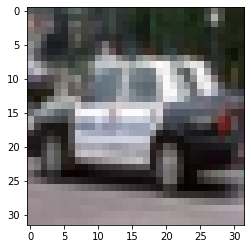

In [ ]:
(x_train, y_train) = load_cifar(1, 10)
plt.imshow((x_train[150,:,:,:]+1)/2)

In [ ]:
if mode == 'build':

    gan = WGAN(input_dim = (32,32,3)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, 128)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
BATCH_SIZE = 128
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

In [ ]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

2251 [D loss: (-0.034)(R -0.058, F -0.009)]  [G loss: 0.005] 
2252 [D loss: (-0.015)(R -0.045, F 0.015)]  [G loss: 0.001] 
2253 [D loss: (-0.014)(R -0.028, F -0.000)]  [G loss: 0.001] 
2254 [D loss: (-0.011)(R -0.029, F 0.008)]  [G loss: 0.012] 
2255 [D loss: (-0.014)(R -0.036, F 0.008)]  [G loss: 0.015] 
2256 [D loss: (-0.014)(R -0.034, F 0.005)]  [G loss: 0.017] 
2257 [D loss: (-0.019)(R -0.046, F 0.007)]  [G loss: 0.020] 
2258 [D loss: (-0.017)(R -0.050, F 0.016)]  [G loss: 0.013] 
2259 [D loss: (-0.015)(R -0.052, F 0.022)]  [G loss: 0.005] 
2260 [D loss: (-0.012)(R -0.055, F 0.030)]  [G loss: -0.011] 
2261 [D loss: (-0.019)(R -0.067, F 0.030)]  [G loss: -0.007] 
2262 [D loss: (-0.015)(R -0.068, F 0.038)]  [G loss: -0.012] 
2263 [D loss: (-0.024)(R -0.084, F 0.036)]  [G loss: -0.009] 
2264 [D loss: (-0.016)(R -0.074, F 0.041)]  [G loss: -0.014] 
2265 [D loss: (-0.014)(R -0.069, F 0.041)]  [G loss: -0.017] 
2266 [D loss: (-0.019)(R -0.088, F 0.049)]  [G loss: -0.026] 
2267 [D loss: (

KeyboardInterrupt: ignored

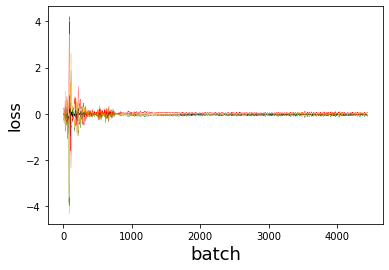

In [ ]:
gan.sample_images(RUN_FOLDER)
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()